## Result Visualization ##

In this part of the project we will visualize concrete examples from action values given by our model and evaluate the capabilities and limitations of our model.

First we load the data from the previous step. If you have not already you should run the file 2_Training_Model.ipynb to retrieve the data and save it to a file.

In [802]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np
from matplotlib.patches import Circle, FancyArrowPatch, Rectangle, RegularPolygon, Polygon
from matplotlib.patheffects import withStroke
from matplotlib import animation
import cmasher as cmr
import matplotlib.cm as cm
import matplotlib.colorbar as cbar

df_model = pd.read_pickle("data/data_cleaned_trained.pkl")

Once the data is loading we can start with the visualization, we use this function to plot game states and action sequences.

Team: Argentina


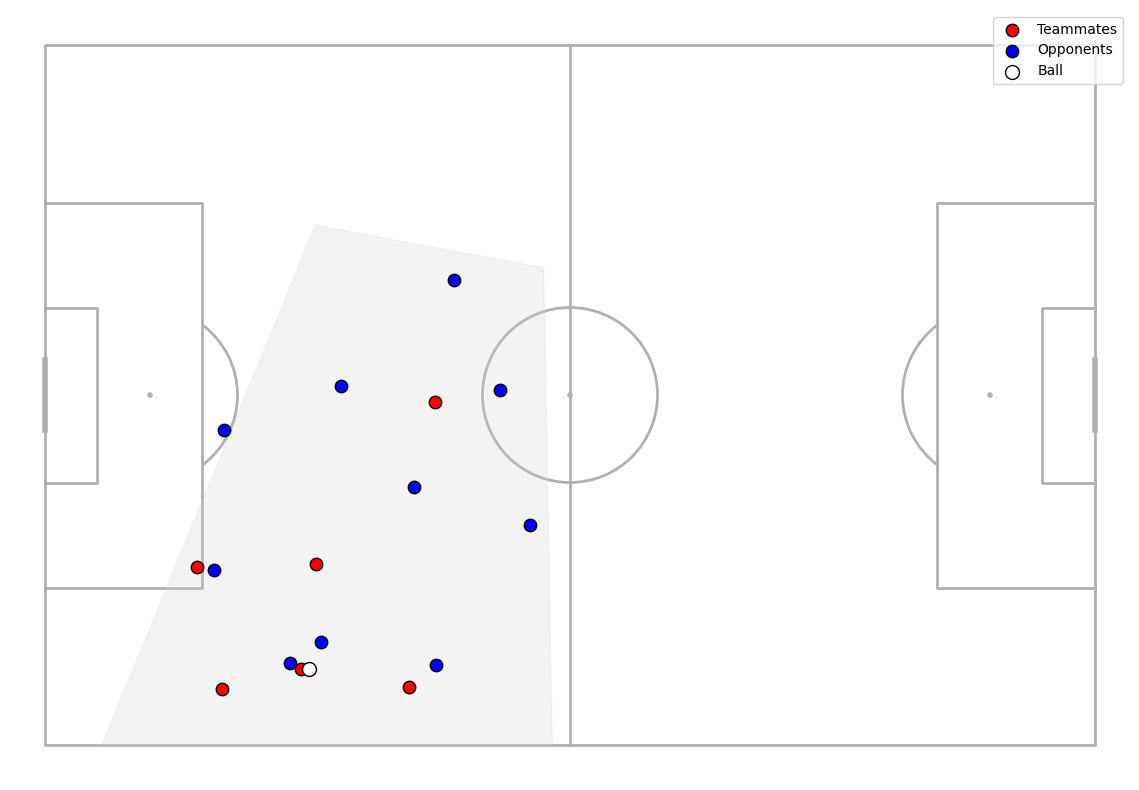

In [803]:
def plot_event_with_360(event_row, show_event_location=True):
    p = Pitch(pitch_type='statsbomb')
    fig, ax = p.draw(figsize=(12, 8))

    if isinstance(event_row['visible_area'], list) and len(event_row['visible_area']) >= 2:
        visible_area = np.array(event_row['visible_area']).reshape(-1, 2)
        p.polygon([visible_area], color='lightgray', alpha=0.25, ax=ax)

        if isinstance(event_row['freeze_frame'], list) and len(event_row['freeze_frame']) > 0:
            freeze_frame_df = pd.DataFrame(event_row['freeze_frame'])

            teammate_locs = freeze_frame_df[freeze_frame_df['teammate']]
            opponent_locs = freeze_frame_df[~freeze_frame_df['teammate']]

            p.scatter(teammate_locs['x'], teammate_locs['y'],
                      c='red', s=80, ec='k', ax=ax, label='Teammates')
            p.scatter(opponent_locs['x'], opponent_locs['y'],
                      c='blue', s=80, ec='k', ax=ax, label='Opponents')
    else:
        print("No visible_area available; only plotting event location.")

    if show_event_location and ('x' in event_row and 'y' in event_row):
        if pd.notna(event_row['x']) and pd.notna(event_row['y']):
            p.scatter(event_row['x'] + 1, event_row['y'],
                      c='white', s=100, ax=ax, ec='k', label='Ball')

            label_text = event_row.get('type_name', 'Event')
            if pd.notna(event_row.get('sub_type_name')):
                label_text += f" ({event_row['sub_type_name']})"

    ax.legend()
    plt.show()

idx = 3678

event_row = df_model.iloc[idx]
print(f"Team: {event_row['team_name']}")

plot_event_with_360(event_row)

In [804]:
SCENARIO = "57c5911b-9d18-4c11-8975-c73e81ed0940" 

In [805]:
LOW_VALUE_ACTIONS = ['ball recovery']


OFFENSIVE_ACTIONS = ['shot', 'pass', 'dribble', 'carry']
DEFENSIVE_ACTIONS = ['interception', 'tackle', 'block', 'clearance']

def fix_coordinates(sequence):
    sequence = sequence.copy()
    attacking_team = None

    for idx, row in sequence.iterrows():
        team = row.get('team_name')
        action = str(row.get('type_name', '')).lower()

        if attacking_team is None:
            attacking_team = team

        is_defending = team != attacking_team

        if is_defending:
            if pd.notna(row['x']):
                sequence.at[idx, 'x'] = 120 - row['x']
            if pd.notna(row['y']):
                sequence.at[idx, 'y'] = 80 - row['y']

        if is_defending and action in ['pass', 'carry', 'dribble', 'shot']:
            attacking_team = team

    return sequence

def get_action_chain(df, event_id, window=6):
    df = df.reset_index(drop=True)
    pos = df.query("id == @event_id").index

    if len(pos) == 0:
        raise ValueError(f"Event ID '{event_id}' not found.")
    pos = pos[0]

    chain = []
    picked_indices = set()
    i = pos

    while len(chain) < window and i >= 0:
        row = df.iloc[i]
        action = str(row.get("type_name", "")).lower()

        if i in picked_indices:
            i -= 1
            continue

        if action in LOW_VALUE_ACTIONS:
            for j in range(i - 1, -1, -1):
                prev_row = df.iloc[j]
                prev_action = str(prev_row.get("type_name", "")).lower()
                if prev_action not in LOW_VALUE_ACTIONS and j not in picked_indices:
                    chain.insert(0, prev_row)
                    picked_indices.add(j)
                    break
        else:
            chain.insert(0, row)
            picked_indices.add(i)

        i -= 1

    return pd.DataFrame(chain)

In [806]:
def plot_action_chain_by_id(df, event_id):
    event_pos = df.reset_index(drop=True).query("id == @event_id").index

    if len(event_pos) == 0:
        print(f"[ERROR] Event ID '{event_id}' not found in DataFrame.")
        return

    pos = event_pos[0]
    start_pos = max(0, pos - 5)
    sequence = get_action_chain(df, event_id)
    sequence = fix_coordinates(sequence)

    if sequence.empty:
        print(f"[ERROR] No sequence found for event ID '{event_id}'")
        return

    fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 4]})
    table_ax, pitch_ax = axs
    table_ax.axis("off")

    col_labels = ['#', 'TIME', 'PLAYER', 'ACTION', r'$P_{scores}$', 'VALUE']
    cell_text = []

    for display_idx, (_, row) in enumerate(sequence.iterrows(), 1):
        time = f"{int(row.get('minute', 0))}m{int(row.get('second', 0))}s"
        player = row.get('player_name', 'Unknown')
        action = row.get('type_name', 'Action').lower()
        pscore = round(row.get('predicted_goal_prob', 0.0), 2)
        value = round(row.get('action_value', 0.0), 2)
        sign = "+" if value >= 0 else ""
        cell_text.append([display_idx, time, player, action, f"{pscore:.2f}", f"{sign}{value:.2f}"])

    table_ax.table(cellText=cell_text, colLabels=col_labels, cellLoc='center',
                   loc='upper center', colWidths=[0.05, 0.15, 0.2, 0.2, 0.15, 0.15])

    pitch = Pitch(pitch_type='statsbomb', pitch_color='#a8bc95', line_color='white')
    pitch.draw(ax=pitch_ax)


    for i in range(len(sequence)):
        row = sequence.iloc[i]
        x, y = row.get('x'), row.get('y')
        if pd.isna(x) or pd.isna(y):
            continue

        if i > 0:
            prev_row = sequence.iloc[i - 1]
            x0, y0 = prev_row.get('x'), prev_row.get('y')
            if pd.notna(x0) and pd.notna(y0):
                prev_action = str(prev_row.get('type_name', '')).lower()
                if any(word in prev_action for word in ['pass', 'shot']):
                    linestyle = 'solid'
                elif any(word in prev_action for word in ['carry', 'duel', 'dribble']):
                    linestyle = 'dashed'
                else:
                    linestyle = 'solid'

                pitch_ax.annotate(
                    '',
                    xy=(x, y),
                    xytext=(x0, y0),
                    arrowprops=dict(
                        arrowstyle="->",
                        color='black',
                        lw=2,
                        linestyle=linestyle,
                        alpha=0.6
                    )
                )

        action = str(row.get('type_name', '')).lower()
        value = round(row.get('action_value', 0.0), 2)

        if 'shot' in action:
            marker = Rectangle((x - 1, y - 1), 2, 2, color='blue', ec='k')
        elif 'dribble' in action or 'take on' in action:
            marker = RegularPolygon((x, y), numVertices=3, radius=2, orientation=np.pi / 2, color='blue', ec='k')
        else:
            marker = Circle((x, y), radius=2, color='lightblue', ec='k')

        pitch_ax.add_patch(marker)
        display_idx = i + 1
        y_offset = 4 - (display_idx % 3) * 2

        pitch_ax.text(
            x, y - y_offset,
            f"({display_idx}) {action}\n{value:+.2f}",
            fontsize=10,
            ha='center', va='top',
            color='white',
            weight='bold',
            path_effects=[withStroke(linewidth=2, foreground='black')]
        )

    plt.tight_layout()
    plt.show()

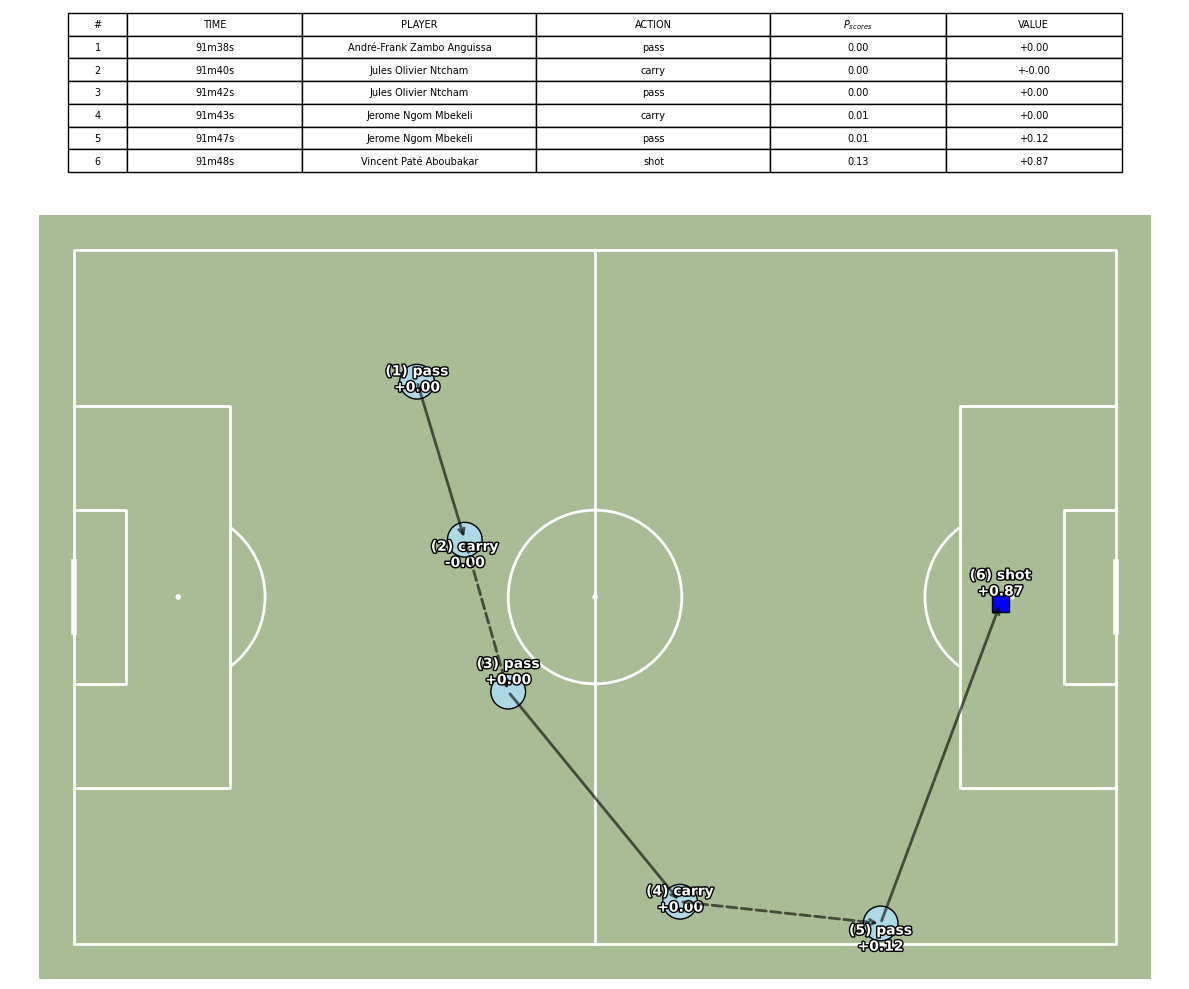

In [807]:
plot_action_chain_by_id(df_model, SCENARIO)

In [808]:
# 17949ad2-d653-49cb-95e4-2efe585438dc f7164861-b772-4dfb-96d7-37e3ec5bfefd = Japan Comeback 57c5911b-9d18-4c11-8975-c73e81ed0940 = Cameroon vs Brazil

In [809]:

def animate_action_chain(df, event_id, window=6, save_path=None):
    sequence = get_action_chain(df, event_id, window=window)
    sequence = fix_coordinates(sequence)

    if sequence.empty:
        print(f"[ERROR] No sequence found for event ID '{event_id}'")
        return

    team_names = sequence['team_name'].unique()
    if len(team_names) >= 2:
        team1, team2 = team_names[0], team_names[1]
    elif len(team_names) == 1:
        team1 = team_names[0]
        match_id = sequence.iloc[0].get('match_id')
        if match_id and 'match_id' in df.columns and 'team_name' in df.columns:
            teams_in_match = df[df['match_id'] == match_id]['team_name'].unique()
            team2 = [t for t in teams_in_match if t != team1]
            team2 = team2[0] if team2 else "Opponent"
        else:
            team2 = "Opponent"
    else:
        team1, team2 = "Team", "Opponent"

    pitch = Pitch(pitch_type='statsbomb', pitch_color='#a8bc95', line_color='white')
    fig, (ax, ax_bar) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [3, 1]})
    pitch.draw(ax=ax)

    teammate_markers = [ax.plot([], [], 'o', color='blue', markersize=10, markeredgecolor='black')[0] for _ in range(11)]
    opponent_markers = [ax.plot([], [], 'o', color='red', markersize=10, markeredgecolor='black')[0] for _ in range(11)]

    visible_area_poly = Polygon(np.zeros((4, 2)), closed=True, color='purple', alpha=0.3)
    ax.add_patch(visible_area_poly)

    annotations, arrows = [], []
    bars = ax_bar.bar(
        ['P(Goal)', 'P(Concede)'],
        [0, 0],
        color=["#59af8c", "#f05850"],
        width=0.2
    )
    ax_bar.set_xticks([0, 1])
    ax_bar.set_xticklabels(['P(Goal)', 'P(Concede)'])

    ax_bar.set_title('Predicted Goal Probability Over Time')
    ax_bar.set_ylim(0, 0.5)
    ax_bar.set_yticks(np.arange(0, 0.51, 0.1))
    ax_bar.set_ylabel('P(Goal)')

    from matplotlib.lines import Line2D
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label=team1, markerfacecolor='blue', markeredgecolor='black', markersize=10),
        Line2D([0], [0], marker='o', color='w', label=team2, markerfacecolor='red', markeredgecolor='black', markersize=10)
    ]
    ax.legend(handles=legend_handles, loc='upper right', fontsize=12, frameon=True)

    def update(frame):
        row = sequence.iloc[min(frame, len(sequence) - 1)]

        if hasattr(row, 'visible_area') and row.visible_area:
            try:
                visible_coords = np.array(row.visible_area).reshape(-1, 2)

                attacking_team = sequence.iloc[0].get("team_name")
                is_defending = row.get("team_name") != attacking_team

                if is_defending:
                    visible_coords[:, 0] = 120 - visible_coords[:, 0]  
                    visible_coords[:, 1] = 80 - visible_coords[:, 1]  

                if visible_coords.shape[0] >= 3:
                    visible_area_poly.set_xy(visible_coords)
                else:
                    visible_area_poly.set_xy(np.zeros((4, 2)))
            except Exception:
                visible_area_poly.set_xy(np.zeros((4, 2)))
        else:
            visible_area_poly.set_xy(np.zeros((4, 2)))

        for ann in annotations:
            ann.remove()
        annotations.clear()

        for arr in arrows:
            arr.remove()
        arrows.clear()

        if isinstance(row.freeze_frame, list):
            freeze_frame_df = pd.DataFrame(row.freeze_frame)

            attacking_team = sequence.iloc[0].get("team_name")
            is_defending = row.get("team_name") != attacking_team

            if is_defending:
                if 'x' in freeze_frame_df.columns:
                    freeze_frame_df['x'] = 120 - freeze_frame_df['x']
                if 'y' in freeze_frame_df.columns:
                    freeze_frame_df['y'] = 80 - freeze_frame_df['y']

            teammates = freeze_frame_df[freeze_frame_df['teammate']]
            opponents = freeze_frame_df[~freeze_frame_df['teammate']]



            for i, marker in enumerate(teammate_markers):
                if i < len(teammates):
                    marker.set_data([teammates.iloc[i].x], [teammates.iloc[i].y])
                else:
                    marker.set_data([], [])

            for i, marker in enumerate(opponent_markers):
                if i < len(opponents):
                    marker.set_data([opponents.iloc[i].x], [opponents.iloc[i].y])
                else:
                    marker.set_data([], [])

        predicted_goal_prob = row.get('predicted_goal_prob', 0)
        predicted_concede_prob = row.get('predicted_concede_prob', 0)
        bars[0].set_height(predicted_goal_prob)
        bars[1].set_height(predicted_concede_prob)
        bars[0].set_color("#59af8c")
        bars[1].set_color("#f05850")
        ax_bar.set_ylim(0, 0.4)
        ax_bar.set_yticks(np.arange(0, 0.41, 0.1))

        for i in range(1, frame + 1):
            prev_row = sequence.iloc[i - 1]
            curr_row = sequence.iloc[i]

            x0, y0 = prev_row.get('x'), prev_row.get('y')
            x1, y1 = curr_row.get('x'), curr_row.get('y')

            if pd.notna(x0) and pd.notna(y0) and pd.notna(x1) and pd.notna(y1):
                prev_action = str(prev_row.get('type_name', '')).lower()
                if any(word in prev_action for word in ['pass', 'shot']):
                    linestyle = 'solid'
                elif any(word in prev_action for word in ['carry', 'duel', 'dribble']):
                    linestyle = 'dashed'
                else:
                    linestyle = 'solid'

                arrow = ax.annotate(
                    '', xy=(x1, y1), xytext=(x0, y0),
                    arrowprops=dict(
                        arrowstyle='->',
                        lw=2,
                        color='black',
                        linestyle=linestyle,
                        alpha=0.6
                    )
                )
                arrows.append(arrow)

        for i in range(frame + 1):
            row = sequence.iloc[i]
            x, y = row.get('x'), row.get('y')
            action = str(row.get('type_name', '')).lower()
            value = round(row.get('action_value', 0.0), 2)
            display_idx = i + 1
            y_offset = 4 - (display_idx % 3) * 2
            ann = ax.text(
                x, y - y_offset,
                f"{value:+.2f} {action} ({display_idx})",
                fontsize=10,
                ha='center', va='top',
                color='white',
                weight='bold',
                path_effects=[withStroke(linewidth=2, foreground='black')]
            )
            annotations.append(ann)

        return (
            teammate_markers +
            opponent_markers +
            [visible_area_poly] +
            list(bars) +
            annotations +
            arrows
        )

    anim = animation.FuncAnimation(fig, update, frames=len(sequence), interval=200, blit=False)

    if save_path:
        anim.save(save_path, dpi=150, fps=1, extra_args=['-vcodec', 'libx264'])

    plt.show()


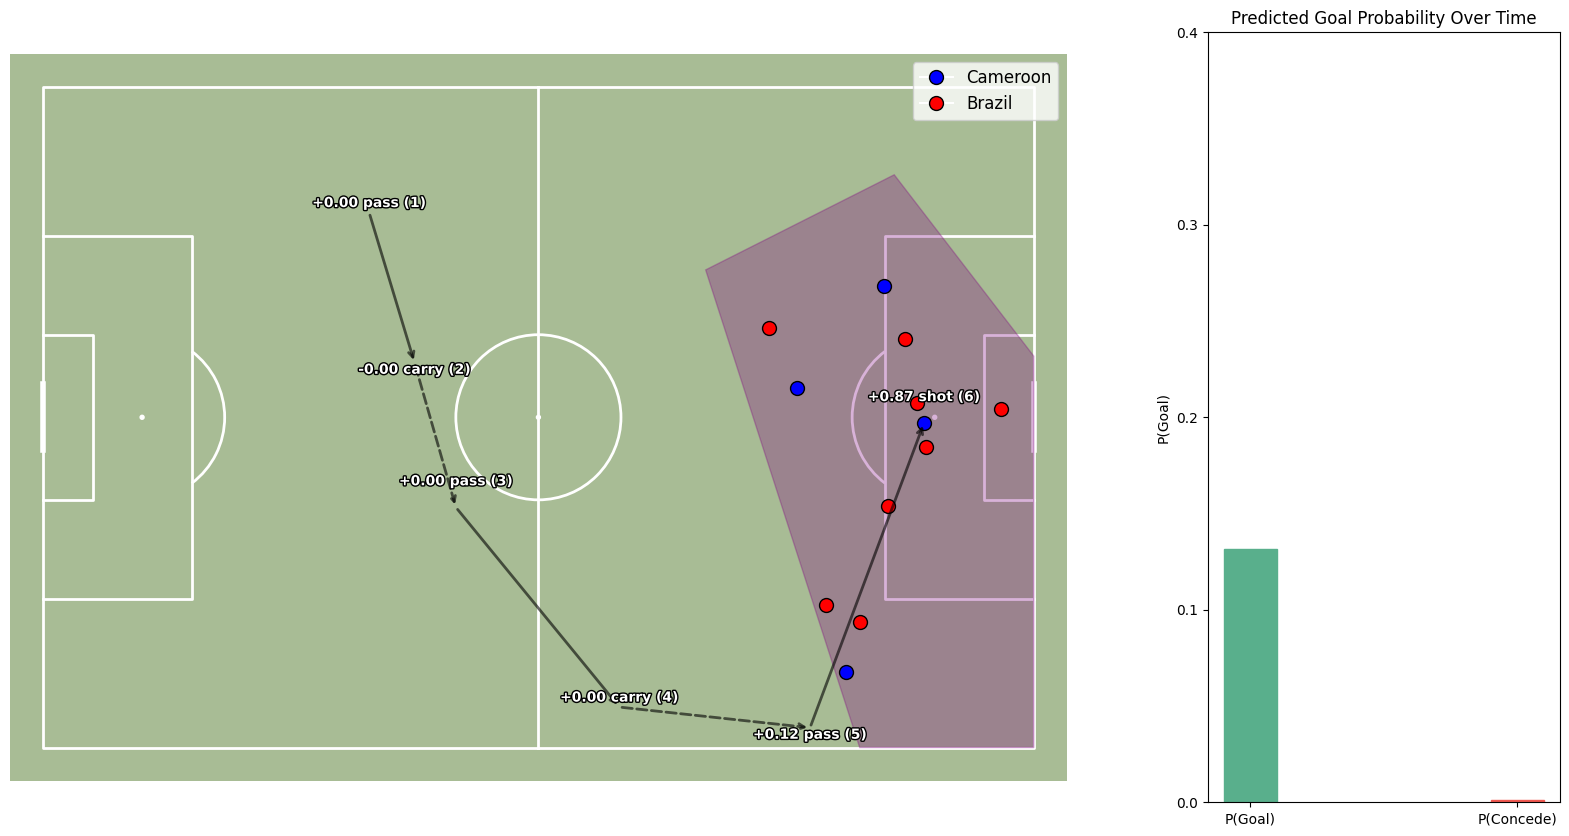

In [810]:
animate_action_chain(df_model, SCENARIO, save_path='action_chain_animation.mp4')

In [811]:
def plot_team_goal_prob_heatmap(team_id, player_id=None, df_path="data/data_cleaned_trained.pkl"):
    # Load data
    df = pd.read_pickle(df_path)

    # Filter by team (and player if specified)
    if player_id is not None:
        df_filtered = df[
            (df['team_id'] == team_id) &
            (df['player_id'] == player_id) &
            (df['predicted_goal_prob'].notna())
        ]
    else:
        df_filtered = df[
            (df['team_id'] == team_id) &
            (df['predicted_goal_prob'].notna())
        ]

    # Filter out penalty shots
    if 'sub_type_name' in df_filtered.columns:
        df_filtered = df_filtered[~df_filtered['sub_type_name'].str.lower().eq('penalty')]

    if df_filtered.empty:
        print(f"[INFO] No events with predicted_goal_prob for team_id {team_id}" +
              (f" and player_id {player_id}" if player_id else ""))
        return

    team_name = df_filtered["team_name"].iloc[0]
    title = f"Heatmap of Predicted Goal Probability for {team_name}"
    if player_id:
        player_name = df_filtered["player_name"].iloc[0]
        title += f" - {player_name}"

    # Draw pitch
    pitch = Pitch(
        pitch_type='statsbomb',
        line_color='#cfcfcf',
        pitch_color='#040d13',
        stripe=False,
        line_zorder=2
    )
    fig, ax = pitch.draw(figsize=(10, 6))
    ax.set_title(title, fontsize=14)

    # Heatmap config
    cmap = cmr.ember
    kde = pitch.kdeplot(
        df_filtered['x'],
        df_filtered['y'],
        ax=ax,
        fill=True,
        cmap=cmap,
        levels=100,
        weights=df_filtered['predicted_goal_prob'],
        thresh=0.01,
        alpha=0.7,
        zorder=1
    )

    # Add colorbar
    sm = cm.ScalarMappable(cmap=cmap)
    sm.set_array(df_filtered['predicted_goal_prob'])
    cbar_obj = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, fraction=0.04)
    cbar_obj.set_label('Predicted Goal Probability', fontsize=12)
    cbar_obj.ax.tick_params(labelsize=10)

    plt.show()


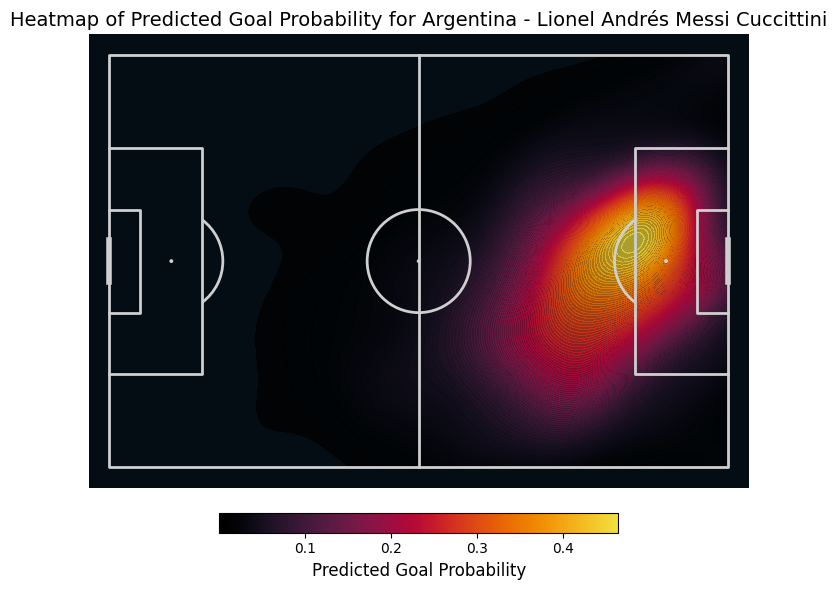

In [812]:
plot_team_goal_prob_heatmap(team_id=779, player_id=5503)